In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 19 to 20) 

**Due date: see the [Apr 07, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

For the categorical feature of region we have separate measurements. I can see this as there a 54 unique regions present in the dataset, and all of them have corresponding prices. We also seem to have separate measurements for the type feature, as the avocados will be priced differently depending on whether they're organic or not. 

In [9]:
df_train["region"].nunique()

54

In [10]:
df_train["type"].nunique()

2

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In this dataset, it seems like the data is pretty equally spaced, with about the same amount of measurements taken at a 7 day increment. One can see this is the case for various regions and types of avocados. 

In [11]:
def plot_time_spacing_distribution(df, region="Albany", type  = "conventional"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]

    type_data = df[df["type"] == type]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return

    if type_data.empty:
        print(f"No data available for type: {type}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region} and {type}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Code adapted from tutorial 7

Time spacing counts for Albany:
Date
0 days    143
7 days    142
Name: count, dtype: int64



/var/folders/j9/68ql7jwj6zn7mr_22x6c14zr0000gn/T/ipykernel_3378/1251159895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


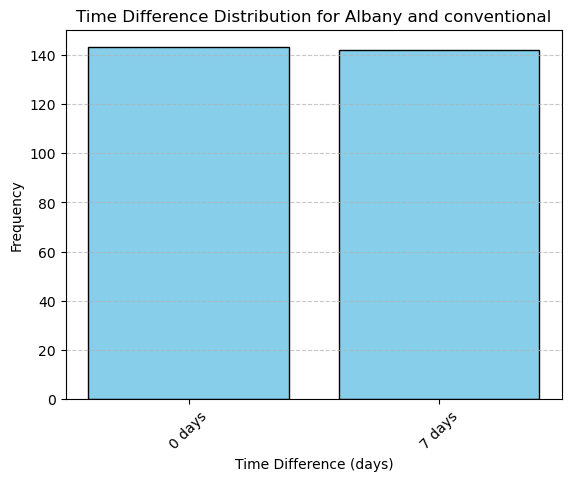

In [12]:
plot_time_spacing_distribution(df_train)

Time spacing counts for Albany:
Date
0 days    143
7 days    142
Name: count, dtype: int64



/var/folders/j9/68ql7jwj6zn7mr_22x6c14zr0000gn/T/ipykernel_3378/1251159895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


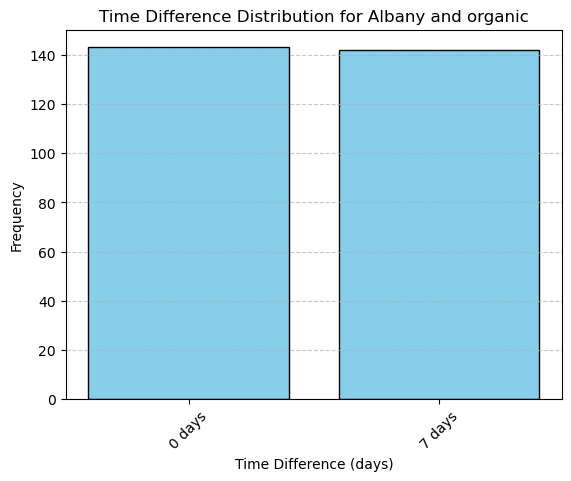

In [13]:
plot_time_spacing_distribution(df_train, type = "organic")

Time spacing counts for WestTexNewMexico:
Date
0 days    140
7 days    142
Name: count, dtype: int64



/var/folders/j9/68ql7jwj6zn7mr_22x6c14zr0000gn/T/ipykernel_3378/1251159895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


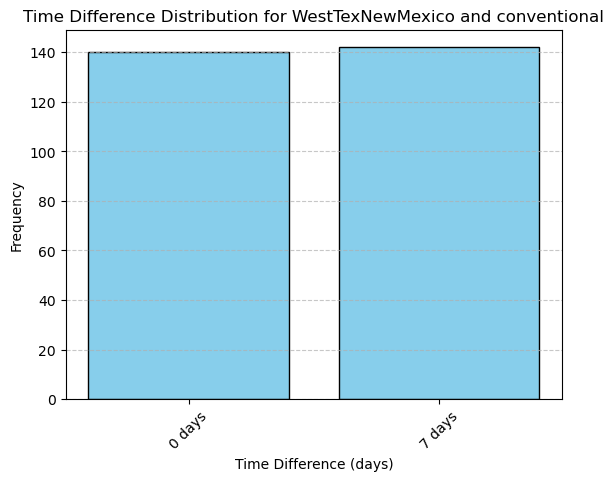

In [14]:
plot_time_spacing_distribution(df_train, region = "WestTexNewMexico")

In [15]:
df_train["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

/var/folders/j9/68ql7jwj6zn7mr_22x6c14zr0000gn/T/ipykernel_3378/1251159895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Time spacing counts for Seattle:
Date
0 days    143
7 days    142
Name: count, dtype: int64



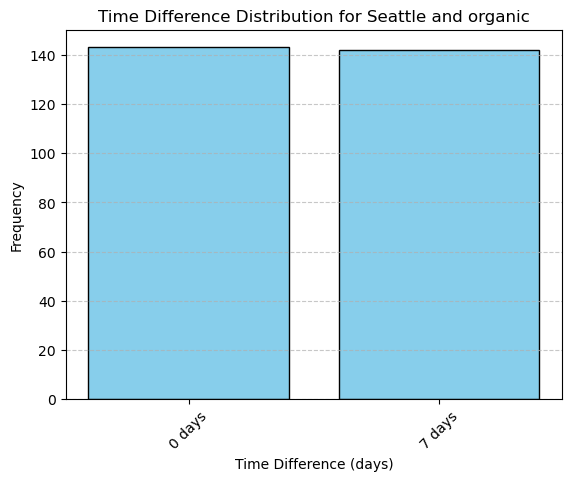

In [16]:
plot_time_spacing_distribution(df_train, region = "Seattle", type = "organic")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

Looking at the names for all the regions, there seems to be some overlap. For example, I can see the regions "TotalUS", "California", and "LosAngeles". These 3 regions have overlap, as Total US would be the country, California would be a state in the country of USA, and Log Angeles would be a city inside of the state (which is inside the country). 

In [17]:
df_train["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [18]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [19]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [20]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [21]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

_Type your answer here, replacing this text._

In [22]:
train_y = df_train["AveragePrice"]
test_y = df_test["AveragePrice"]

In [23]:
train_r2 = r2_score(df_train["AveragePriceNextWeek"], train_y)
train_r2

0.8285800937261841

In [24]:
test_r2 = r2_score(df_test["AveragePriceNextWeek"], test_y)
test_r2

0.7631780188583048

In [25]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

The best test score I got was using Ridge with alpha = 0.1, encoding time as a month feature. 

I chose to use the Ridge and RandomForestRegressor models as these are two models that are relatively straightforward to use and can be interpreted (for Ridge with coefficients and RandomForest with feature importances). 

The steps I did followed what was in the time series tutorial, as it systematically made time a more "complex" feature. I first tried making time into just a day since the first day in the set. It makes sense that this didn't work the best (but still not too terrible) as the price of avocado varies throughout the year (depending on when avocado is in season or not the price will change). Days_since doesn't take this into consideration as it just begins from an arbitrary day. Having time encoded as a month worked much better. This makes sense as we can group the prices by a chunk of time, rather than each day. This makes sense as the supply and demand of avocado probably does not change month on a daily basis, but rather on a monthly basis (for example, people may want to eat avocado more often in some months rather than others). I was a bit shocked that RandomForestRegressor didn't do as well as the Ridge model since typically ensembles do quite well. However, I didn't do much hyperparameter turning for either of these models, which could have affected this. For Ridge I tried a few different values of alpha (0.0001, 0.2, for example) but I didn't notice much difference. For RandomForestRegressor I tried some different max depth values (5, 10, 15). More hyperparameter tuning could lead to an even better value for both of these models, however I didn't want to overfit on the test set, or use cross-validation so I stuck with this. 

A test score of 0.805 indicates that majority of the average prices for the next week are being predicted correctly. 

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor 

In [27]:
dates_avo = pd.to_datetime(df_train["Date"])
dates_avo

0       2015-01-04
1       2015-01-11
2       2015-01-18
3       2015-01-25
4       2015-02-01
           ...    
18218   2017-08-27
18219   2017-09-03
18220   2017-09-10
18221   2017-09-17
18222   2017-09-24
Name: Date, Length: 15441, dtype: datetime64[ns]

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNextWeek 

In [29]:
numeric_features = [
    "AveragePrice",
    "Total Volume", 
    "4046", 
    "4225", 
    "4770", 
    "Total Bags", 
    "Small Bags", 
    "Large Bags",
    "XLarge Bags"
]

categorical_features = [
    "type", "region"
]

time_features = ["Date", "year"]

target = ["AveragePriceNextWeek"]

In [30]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

Code adapted from lecture 20

In [31]:
first_day = df_train["Date"].min()

train_df = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
test_df = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

Code adapted from lecture 20.

In [32]:
train_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Days_since
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,0
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,7
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,14
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,21
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,28


In [33]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since"],
    categorical_features,
    time_features, 
    target
)

In [34]:
ridge = Ridge(alpha = 0.1, random_state = 42)
ridge.fit(X_train_enc, y_train)
ridge.score(X_train_enc, y_train)

0.8455786587579314

In [35]:
ridge.score(X_test_enc, y_test)

0.7836454199089383

In [36]:
rf = RandomForestRegressor(random_state = 42, max_depth = 10)
rf.fit(X_train_enc, y_train)
rf.score(X_train_enc, y_train)

0.9056661968107467

In [37]:
rf.score(X_test_enc, y_test)

0.740951397301925

In [38]:
mtrain_df = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
mtest_df = df_test.assign(
    Month=df_test["Date"].apply(lambda x: x.month_name())
)

Code adapted from lecture 20.

In [39]:
mtrain_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,January
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,January
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,January
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,January
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,February


In [40]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    mtrain_df, mtest_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    time_features,
    target
)

In [41]:
ridge = Ridge(alpha = 0.1, random_state = 42)
ridge.fit(X_train_enc, y_train)
ridge.score(X_train_enc, y_train)

0.8480250459007566

In [42]:
ridge.score(X_test_enc, y_test)

0.8051101326774006

In [43]:
rf = RandomForestRegressor(random_state = 42, max_depth = 10)
rf.fit(X_train_enc, y_train)
rf.score(X_train_enc, y_train)

0.9019888977342274

In [44]:
rf.score(X_test_enc, y_test)

0.7811794421465594

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. Time series data may have unequally spaced time points for instances where we collect data at the time that an event we can't control. For example, collecting data at the time an earthquake happens in a certain region would be unequally spaced, because an earthquake won't occur in regular intervals. 
2. Lag based features would struggle with unequally spaced time points. This is because when creating lag we shift the time by a certain increment, however if the increment between the times aren't equal we won't have data in nice increments that we can lag.
3. Ridge is unable to capture the periodic prediction due to bring a linear model, that we are trying to apply on non-linear data. Ridge can either have a positive or negative slope, and is unable to capture the fact that the rentals increase to a peak and then continue to decrease. One can fix this issue by encoding hour of the week and day of the week as a categorical feature, as this allows the model to not have one singular slope for the entire day. Creating a feature interaction between hour of the day and day of the week creates even better predictions as then the slopes aren't the same for everyday.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. If you have 4 classes and 10 features logistic regression will learn 40 coefficients. It learns 40 coefficients because it learns a coefficient for each feature and each class. The model will learn 4 intercepts. It learns 4 intercepts because it learns one intercept per class. 
2. This property is useful when we want to use pre-trained models as feature extractors and then train your own model on these features you extracted. In this case we want to get the feature vector, which is usually extracted from the last layer. The layers are a transformer applying some transformations on the input received to that later. Since neural networks create multiple sequential transformations, these can be thought of as layers used here. 
3. I would probably use transfer learning where we use pre-trained models to extract features. I would use this way because flattening the images can get rid of alot of details that can be helpful in the classification. However, using pre-trained models without doing anything to them isn't a good idea as the model will likely not have the names of the faculty members, therefore not correctly classifying them.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. The issue that happens here is that we don't know when or why customers will churn. Using an approaches such as only using examples with customers that have churned or assuming every customer churns leads to underestimation. Customers who have already churned tend to have shorter time window. If we assume everyone have churned we truncate the time of customers who haven't churned (the time before they truncate would be longer than we assumed).
2. We don't have enough information to answer this question. There is too much unknown about these two customers and the service they have joined. For example, Customer A may leave sooner because they newly joined the service and realized they don't like it (or if it's a weekly subscription so the time remaining subscribed is expected to be low). However, Customer A may also stay for a long time as they newly joined and realized they enjoyed the service a lot. The same ideas can be applied to customer B; they leave first as they have already been subscribed for a long time or they might stay longer as they've enjoyed it for a year and continue to do so. 
3. We can interpret this as meaning that the churning is low for that specific time period. 

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)